#### Build a Basic Chatbot with Langgraph(Graph Api)

There are 3 imp components of Langgraph
1) Edges
2) Nodes
3) State

There are two types of Langgraph 
1) Graph Api
2) Functional Api

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages



##### Creating a state

In [2]:
class State(TypedDict):
    # Message have the type "list". The 'add_message' function 
    #in the annotation defines how this state should be upadted 
    #(in this case it appends the messages to the list instead of overwritting them)
    messages:Annotated[list, add_messages]



In [3]:
import os
from dotenv import load_dotenv
load_dotenv()


True

In [4]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(model='llama3-8b-8192')

In [5]:
## Node Functionality
def chatbot(state:State):
    response=llm.invoke(state["messages"])
    return {"messages":[response]}

In [6]:
graph_builder=StateGraph(State)

#Adding Node
graph_builder.add_node("LLmchatbot",chatbot)
# Adding Edges
graph_builder.add_edge(START,'LLmchatbot')
graph_builder.add_edge('LLmchatbot',END)

## Compile the Graph
graph=graph_builder.compile()


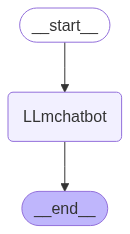

In [7]:
## Visualize the graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    pass 

In [8]:
response_initial=graph.invoke({"messages":"HI"})

In [9]:
response_initial

{'messages': [HumanMessage(content='HI', additional_kwargs={}, response_metadata={}, id='ddf3b5ff-28c2-4b35-a15f-33ad55a7418f'),
  AIMessage(content="Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 11, 'total_tokens': 36, 'completion_time': 0.032911313, 'prompt_time': 0.002764283, 'queue_time': 0.0016624459999999997, 'total_time': 0.035675596}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_5b339000ab', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--aca85244-08f1-43f8-ae53-c72fb6a92349-0', usage_metadata={'input_tokens': 11, 'output_tokens': 25, 'total_tokens': 36})]}

In [10]:
response_initial['messages'][-1].content

"Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [11]:
for event in graph.stream({"messages":"Hi How are you?"}):
    print(event)

{'LLmchatbot': {'messages': [AIMessage(content="I'm just an AI, so I don't have feelings like humans do, but I'm functioning properly and ready to help you with any questions or tasks you have! It's great to chat with you. How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 15, 'total_tokens': 65, 'completion_time': 0.065342002, 'prompt_time': 0.003223567, 'queue_time': 0.0014709839999999998, 'total_time': 0.068565569}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_5b339000ab', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--cafda777-ce93-462e-ace1-69e43a0cd8d6-0', usage_metadata={'input_tokens': 15, 'output_tokens': 50, 'total_tokens': 65})]}}


### Chat Bot with tools with the help of Langgrapgh

In [12]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_result=2)
tool.invoke("what is Langgraph")

{'query': 'what is Langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
   'title': 'LangGraph Tutorial: What Is LangGraph and How to Use It?',
   'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent interaction

In [13]:
## Custom Function
def multiply(a:int,b:int)->int:
    """Multiply a and b
    Args:
        a (int): First int
        b (int): Second int

    Returns:
        int:output int
    """ 
    return a*b   

In [14]:
tools=[tool,multiply]

In [15]:
llm_with_tool= llm.bind_tools(tools)

llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001EA1075EF50>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001EA1085A090>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list 

### Creating a Stategraph

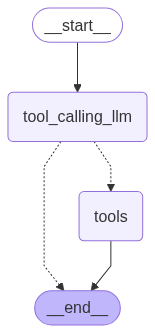

In [16]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode, tools_condition

# Node Defination
def tool_calling_llm(state:State):
    return{"messages":[llm_with_tool.invoke(state["messages"])]}

## Graph
builder= StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node('tools',ToolNode(tools))

## Add the Edges
builder.add_edge(START,'tool_calling_llm')
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools",END)

# Compile the grapgh 
graph=builder.compile()

from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
response=graph.invoke({'messages':'what are the recent ai news'})

In [18]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what are the recent ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (nqhftmk0j)
 Call ID: nqhftmk0j
  Args:
    query: recent ai news
    search_depth: advanced
    time_range: week
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.zdnet.com/article/microsoft-is-saving-millions-with-ai-and-laying-off-thousands-where-do-we-go-from-here/", "title": "Microsoft is saving millions with AI and laying off thousands - where do we go from here? - ZDNET", "score": 0.7244226, "published_date": "Thu, 17 Jul 2025 02:00:00 GMT", "content": "The news comes as several tech companies and leaders have noted, in rapid succession, that AI is poised to replace at least some

In [19]:
response=graph.invoke({"messages":"what is 2 multiplied by 3"})

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is 2 multiplied by 3
================================== Ai Message ==================================
Tool Calls:
  multiply (zsq4ygvj1)
 Call ID: zsq4ygvj1
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


In [20]:
response=graph.invoke({"messages":"what is 2 multiplied by 5 and then multiply by 10"})

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is 2 multiplied by 5 and then multiply by 10
================================== Ai Message ==================================
Tool Calls:
  multiply (kv7e9d19m)
 Call ID: kv7e9d19m
  Args:
    a: 2
    b: 5
  multiply (peamr3h2m)
 Call ID: peamr3h2m
  Args:
    a: 10
    b: 20
================================= Tool Message =================================
Name: multiply

10
================================= Tool Message =================================
Name: multiply

200


In [21]:
response=graph.invoke({"messages":"what is 2 multiplied by 5 and then multiply by 10 and also give me recent news about ukraine."})

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is 2 multiplied by 5 and then multiply by 10 and also give me recent news about ukraine.
================================== Ai Message ==================================
Tool Calls:
  multiply (7pn4s3mn0)
 Call ID: 7pn4s3mn0
  Args:
    a: 2
    b: 5
  multiply (tpqdwf0pt)
 Call ID: tpqdwf0pt
  Args:
    a: 10
    b: 20
  tavily_search (1h86p11ms)
 Call ID: 1h86p11ms
  Args:
    end_date: None
    query: Ukraine news
    search_depth: advanced
    start_date: None
    time_range: None
    topic: news
================================= Tool Message =================================
Name: multiply

10
================================= Tool Message =================================
Name: multiply

200
================================= Tool Message =================================
Name: tavily_search

{"query": "Ukraine news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url":

### ReAct Agent architecture

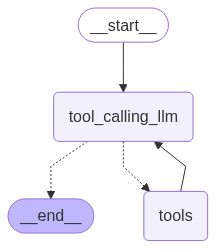

In [22]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode, tools_condition

# Node Defination
def tool_calling_llm(state:State):
    return{"messages":[llm_with_tool.invoke(state["messages"])]}

## Graph
builder= StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node('tools',ToolNode(tools))

## Add the Edges
builder.add_edge(START,'tool_calling_llm')
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools",'tool_calling_llm') #going back to tool calling LLM

# Compile the grapgh 
graph=builder.compile()

from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
response=graph.invoke({"messages":"Give me recent news about India Vs England Test Match and after that do 2 multiply by 10 and then multiply 30 to it "})

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me recent news about India Vs England Test Match and after that do 2 multiply by 10 and then multiply 30 to it 
================================== Ai Message ==================================

I can do that. Here's the news:

India and England are set to clash in a four-match Test series, starting from February 5, 2021, at the Chennai's M.A. Chidambaram Stadium. England won the three-match Test series 3-1 in the previous series in 2018. India will be looking to avenge their defeat and gain an upper hand in the World Test Championship. The series is highly anticipated, considering the strong squads of both teams.

Now, let's perform the multiplication operations:

1. Multiply 2 by 10: 2 * 10 = 20
2. Multiply 30 by 20: 30 * 20 = 600

Here's the output:
Tool Calls:
  multiply (pjm4mfk5s)
 Call ID: pjm4mfk5s
  Args:
    a: 2
    b: 10
  multiply (ghbkjbhaz)
 Call ID: ghbkjbhaz
  Args:
    a: 30
    b: 2

## Adding Memory to Agentic Graph.

In [28]:
response=graph.invoke({"messages":"Hey my name is Meet!"})

for m in response["messages"]:
    m.pretty_print()


================================ Human Message =================================

Hey my name is Meet!
================================== Ai Message ==================================

Nice to meet you, Meet!


In [32]:
response=graph.invoke({"messages":"What is my name"})

for m in response["messages"]:
    m.pretty_print()


BadRequestError: Error code: 400 - {'error': {'message': "tool call validation failed: attempted to call tool 'get_name' which was not request.tools", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<tool-use>\n{\n    "tool_calls": [\n        {\n            "id": "pending",\n            "type": "function",\n            "function": {\n                "name": "get_name"\n            },\n            "parameters": {\n                "query": "What is my name"\n            }\n        }\n    ]\n}\n</tool-use>'}}

So you will see it says bad request coz it doesn't have any clue. But, now we will do this.

##### adding memory to our state graph.

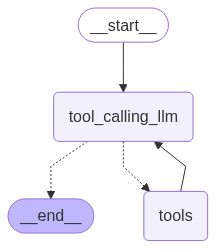

In [36]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory=MemorySaver()

# Node Defination
def tool_calling_llm(state:State):
    return{"messages":[llm_with_tool.invoke(state["messages"])]}

## Graph
builder= StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node('tools',ToolNode(tools))

## Add the Edges
builder.add_edge(START,'tool_calling_llm')
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools",'tool_calling_llm') #going back to tool calling LLM

# Compile the grapgh 
graph=builder.compile(checkpointer=memory)

from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

For adding a memoery we should have a thread ID which is unique in configurable key having a unique value.

In [37]:
config= {"configurable":{"thread_id":"1"}}

graph.invoke({"messages":"Hi My name is Meet Bhatt"},config=config)

response

{'messages': [HumanMessage(content='Hey my name is Meet!', additional_kwargs={}, response_metadata={}, id='db23c299-c494-42b7-af28-3c2e63a832b0'),
  AIMessage(content='Nice to meet you, Meet!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 2909, 'total_tokens': 2917, 'completion_time': 0.017887686, 'prompt_time': 0.323185379, 'queue_time': 0.06460888399999998, 'total_time': 0.341073065}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_0fb809dba3', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--751ecf73-2610-45ab-9188-258af818a35b-0', usage_metadata={'input_tokens': 2909, 'output_tokens': 8, 'total_tokens': 2917})]}

In [38]:
response['messages'][-1].content

'Nice to meet you, Meet!'

In [39]:
response=graph.invoke({"messages":"what is my name. Do you remember"},config=config)
print(response['messages'][-1].content)

I remember! Your name is Meet Bhatt.


### Streaming in Langgrapgh.

In [53]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [54]:
def Superbot(state:State):
    return{"messages":[llm.invoke(state["messages"])]}


visualizing

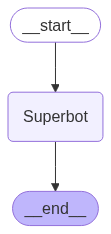

In [55]:
graph=StateGraph(State)

## node
graph.add_node("Superbot",Superbot)

## Edges
graph.add_edge(START,"Superbot")
graph.add_edge("Superbot",END)

graph_builder=graph.compile(checkpointer=memory)

## Display
from IPython.display import Image, display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [56]:
## Invocation:

config={"configurable":{"thread_id":"1"}}

graph_builder.invoke({'messages':"Hey I am Meet! I love Cricket."},config=config)
        

{'messages': [HumanMessage(content='Hey I am Meet! I love Cricket.', additional_kwargs={}, response_metadata={}, id='38843408-09a5-4eb1-afa8-77c3f54d60ba'),
  AIMessage(content="Hello Meet! Nice to meet you!\n\nCricket is an amazing sport, isn't it? So many exciting matches and thrilling moments! Who's your favorite team or player?\n\nAre you a fan of Test cricket, One-Day Internationals (ODIs), or Twenty20 (T20) cricket?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 19, 'total_tokens': 81, 'completion_time': 0.101999606, 'prompt_time': 0.007011658, 'queue_time': 0.065343074, 'total_time': 0.109011264}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_0fb809dba3', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--0ca83f5d-f617-41cb-b58a-51fd09241d1a-0', usage_metadata={'input_tokens': 19, 'output_tokens': 62, 'total_tokens': 81})]}

#### Streaming 

Methods : .stream()  and   astream()

    -- These methods are sync and async for streaming back the results
    
Additional Parameters:

    -- Values: This streams full state of the graph after each node is called
    -- Updates: This streams update to the State of the graph after each    node is called.

In [58]:
config={"configurable":{"thread_id":"3"}}

for chunk in graph_builder.stream({"messages":'Hi my name is meet and I love soccer.'},config=config,stream_mode='values'):
    print(chunk)

{'messages': [HumanMessage(content='Hi my name is meet and I love soccer.', additional_kwargs={}, response_metadata={}, id='8492ab80-9940-4a51-a179-43111f4dc161'), HumanMessage(content='Hi my name is meet and I love soccer.', additional_kwargs={}, response_metadata={}, id='4797e9e5-5997-4bb3-99bb-59f5cba90312')]}
{'messages': [HumanMessage(content='Hi my name is meet and I love soccer.', additional_kwargs={}, response_metadata={}, id='8492ab80-9940-4a51-a179-43111f4dc161'), HumanMessage(content='Hi my name is meet and I love soccer.', additional_kwargs={}, response_metadata={}, id='4797e9e5-5997-4bb3-99bb-59f5cba90312'), AIMessage(content="Hi Meet! Nice to meet you! It's great to hear that you love soccer! Which team is your favorite? Do you play soccer yourself or are you more of a fan who loves watching and following the games?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 40, 'total_tokens': 85, 'completion_time': 0.094767568, '

In [60]:
config={"configurable":{"thread_id":"3"}}

for chunk in graph_builder.stream({"messages":'Hi my name is meet and I love soccer.'},config=config,stream_mode='updates'):
    print(chunk)

{'Superbot': {'messages': [AIMessage(content="Hi Meet! I think we've already established that you love soccer, but it's great to hear it again! Would you like to talk about your favorite team, player, or league? Or maybe you'd like to simulate a soccer match or tournament with me? Just let me know what you'd like to do!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 65, 'prompt_tokens': 187, 'total_tokens': 252, 'completion_time': 0.104437584, 'prompt_time': 0.024154101, 'queue_time': 0.062691958, 'total_time': 0.128591685}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_0fb809dba3', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--d13af07d-19d0-45eb-8f13-22d37eb23864-0', usage_metadata={'input_tokens': 187, 'output_tokens': 65, 'total_tokens': 252})]}}


In [61]:
for chunk in graph_builder.stream({"messages":'I also like F1'},config=config,stream_mode='values'):
    print(chunk)

{'messages': [HumanMessage(content='Hi my name is meet and I love soccer.', additional_kwargs={}, response_metadata={}, id='8492ab80-9940-4a51-a179-43111f4dc161'), HumanMessage(content='Hi my name is meet and I love soccer.', additional_kwargs={}, response_metadata={}, id='4797e9e5-5997-4bb3-99bb-59f5cba90312'), AIMessage(content="Hi Meet! Nice to meet you! It's great to hear that you love soccer! Which team is your favorite? Do you play soccer yourself or are you more of a fan who loves watching and following the games?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 40, 'total_tokens': 85, 'completion_time': 0.094767568, 'prompt_time': 0.038636317, 'queue_time': 0.194066069, 'total_time': 0.133403885}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_0fb809dba3', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--1c70296a-e4ea-494c-adfe-2271f1e0966b-0', usage_metadata={'input_tokens': 40, 'ou